In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string

import time

import re

In [267]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE , SMOTEN

In [13]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from xgboost import XGBClassifier

In [258]:
from sklearn.pipeline import Pipeline
from joblib import dump , load

In [259]:
# Preparing the main corpus
main_df= pd.read_csv('data/reviews.csv')

# Remove nan reviews
df= main_df.copy()
df.dropna(subset= ['Review Text'], inplace= True)

print('main df and clean df shape:',main_df.shape , df.shape)

# X , y

X = df['Review Text']
y= df["Recommended IND"].values.reshape(-1,1)
print("X.shape:", X.shape, '\t y_shape:', y.shape)


X_train, X_test, y_train, y_test = train_test_split(X , y , stratify =y , test_size = 0.3, random_state= 100)
print('train_test_split:',X_train.shape , X_test.shape,'\t', y_train.shape, y_test.shape)

main df and clean df shape: (23486, 11) (22641, 11)
X.shape: (22641,) 	 y_shape: (22641, 1)
train_test_split: (15848,) (6793,) 	 (15848, 1) (6793, 1)


In [128]:
train_feature_set.shape

(15848, 17614)

In [148]:
## Logistic regression

#lr = LogisticRegression()
#lr.fit(train_feature_set,y_train)
#y_pred = lr.predict(test_feature_set)

#cm = confusion_matrix(y_test,y_pred)
#print('Confusion Matrix:\n', cm)
#print("Accuracy: ",round(accuracy_score(y_test,y_pred),3))
#("F1: ",round(f1_score(y_test, y_pred),3))
#print("Recall: ",round(recall_score(y_test,y_pred),3))
#print("percision: ",round(precision_score(y_test, y_pred),3))
#print(classification_report(y_test, y_pred))

In [264]:
# create countvectorizer:
start_time = time.time()

cv = CountVectorizer(binary = True, stop_words= 'english', ngram_range=(1,2) ,min_df = 5, max_df = 0.95)
cv.fit_transform(X_train)
train_feature_set = cv.transform(X_train)
test_feature_set = cv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.13  mins


In [151]:
def model_predictions(model_name, X_train,y_train,X_test, y_test):
    
    model = model_name
    model.fit(X_train, y_train)
    
    print(model_name)
    acc = cross_val_score(model, X_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(model, X_test, y_test, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:  \n", cm)
    print("Classification Report \n", classification_report( y_test, predictions))

In [265]:
lr = LogisticRegression(class_weight= 'balanced')
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression(class_weight='balanced')
Accuracy: 0.875
Confusion Matrix:  
 [[ 869  361]
 [ 475 5088]]
Classification Report 
               precision    recall  f1-score   support

           0       0.65      0.71      0.68      1230
           1       0.93      0.91      0.92      5563

    accuracy                           0.88      6793
   macro avg       0.79      0.81      0.80      6793
weighted avg       0.88      0.88      0.88      6793



In [274]:
 average_precision_score(y_test, predictions, average= 'weighted')

0.9142288276230754

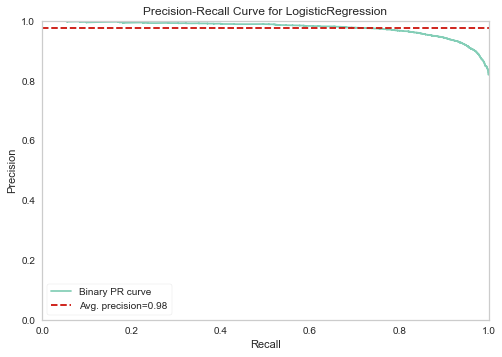

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [271]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    lr,
    per_class=True,
    
)
viz.fit(train_feature_set, y_train)
viz.score(test_feature_set, y_test)
viz.show()

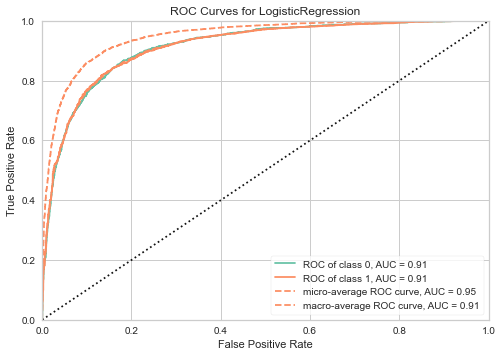

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [277]:
from yellowbrick.classifier import ROCAUC

model = lr
viz = ROCAUC(model)

viz.fit(train_feature_set, y_train)
viz.score(test_feature_set, y_test)
viz.show()

In [248]:
# logistic regresion
lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.883
Confusion Matrix:  
 [[ 700  530]
 [ 250 5313]]
Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.57      0.64      1230
           1       0.91      0.96      0.93      5563

    accuracy                           0.89      6793
   macro avg       0.82      0.76      0.79      6793
weighted avg       0.88      0.89      0.88      6793



In [238]:
pred_proba_df = pd.DataFrame(lr.predict_proba(test_feature_set))
threshold_list = [0.3,0.4,0.45,0.5, 0.51, 0.6]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_f1 = round(f1_score(y_test, y_test_pred.loc[:,1].values),3)
    print('F1: {}'.format(test_f1))


******** For i = 0.3 ******
F1: 0.932

******** For i = 0.4 ******
F1: 0.933

******** For i = 0.45 ******
F1: 0.933

******** For i = 0.5 ******
F1: 0.934

******** For i = 0.51 ******
F1: 0.933

******** For i = 0.6 ******
F1: 0.933


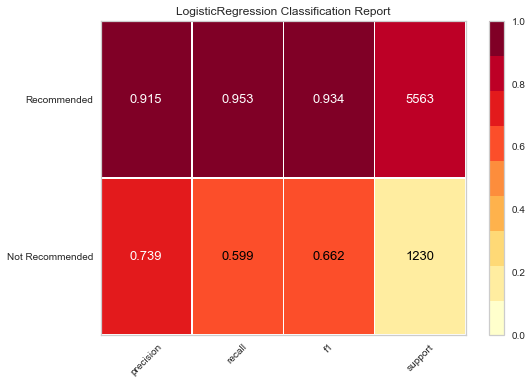

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [159]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(lr, classes=['Not Recommended', 'Recommended'], support=True, )

visualizer.fit(train_feature_set, y_train)  # Fit the visualizer and the model
visualizer.score(test_feature_set, y_test)# Evaluate the model on the test data
for label in visualizer.ax.texts:
    label.set_size(13)
plt.savefig('images/bestmodel.png', dpi=300)
visualizer.show()             # Draw/show the data

In [131]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['unique', 'elegant', 'dressed', 'darling', 'would recommend', 'not bad', 'worried', 'love', 'love top', 'compliments']


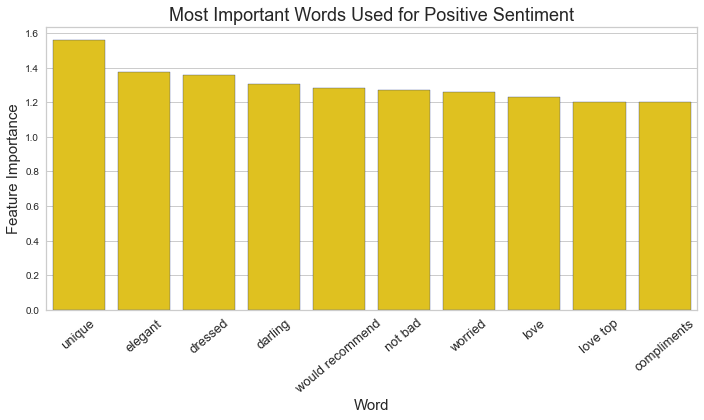

In [231]:
sns.set_palette("Set2", 9)
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]], color= 'gold', alpha = 1, edgecolor=sns.color_palette("dark", 1))
plt.title("Most Important Words Used for Positive Sentiment",fontsize = 18)
x_locs,x_labels = plt.xticks()
plt.xticks(fontsize=13)
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 15)
plt.xlabel('Word', fontsize = 15)
plt.tight_layout()
plt.savefig('images/mostposwords');

In [133]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['wanted love', 'not flattering', 'disappointed', 'cheap', 'shame', 'not recommend', 'weirdly', 'going back', 'returned', 'not worth']


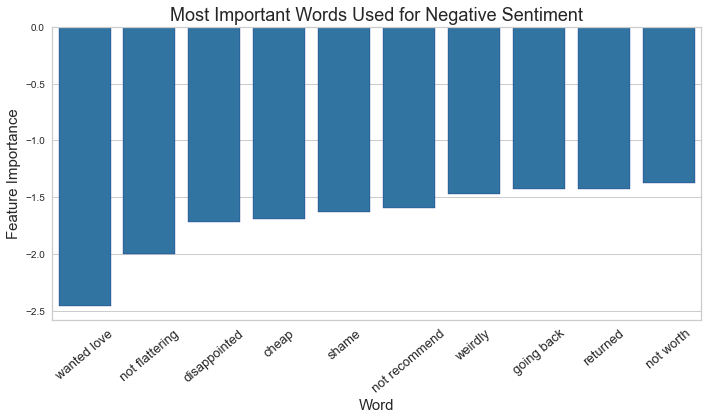

In [232]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]], color= 'tab:blue', alpha = 1, edgecolor=sns.color_palette("dark", 1))
plt.title("Most Important Words Used for Negative Sentiment",fontsize = 18)
x_locs,x_labels = plt.xticks()
plt.xticks(fontsize=13)
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 15)
plt.xlabel('Word', fontsize = 15)
plt.tight_layout()
plt.savefig('images/mostnegwords')

In [ ]:
from yellowbrick.classifier import A

## Building Pipeline

In [261]:
pipe_logistic = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("classifier", LogisticRegression()) #alpha=1 is the default
])
pipe_logistic.fit(X_train, y_train)
predictions = pipe_logistic.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1:', f1_score(y_test, predictions))

Accuracy: 0.8888561754747534
F1: 0.933144425750465


In [262]:
dump(pipe_logistic, 'sentiment.joblib')

['sentiment.joblib']

In [263]:
loaded_model = load('sentiment.joblib')
predictions = loaded_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1:', f1_score(y_test, predictions))

Accuracy: 0.8888561754747534
F1: 0.933144425750465


## Test

In [186]:
test_review = cv.transform(["I love the design and pattern of this top. \
it runs big so an xs was roomy on me but still cute. the neck is wide. \
i returned it bc the material of the top isn't for me. the texture is too soft." ])
lr.predict_proba(test_review)

array([[0.72092959, 0.27907041]])

In [190]:
# create countvectorizer:
start_time = time.time()

cv = CountVectorizer(binary = True, stop_words= sw,  min_df = 5, max_df = 0.95, ngram_range=(1,2))
cv.fit_transform(X_train)
train_feature_set = cv.transform(X_train)
test_feature_set = cv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.05  mins


In [197]:
text= "I love the design and pattern of this top. it runs big so an xs was roomy on me but still cute. the neck is wide. i returned it bc the material of the top is not for me. the texture is too soft." 

In [193]:
lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.891
Confusion Matrix:  
 [[ 705  525]
 [ 257 5306]]
Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.57      0.64      1230
           1       0.91      0.95      0.93      5563

    accuracy                           0.88      6793
   macro avg       0.82      0.76      0.79      6793
weighted avg       0.88      0.88      0.88      6793



In [200]:
test_review = cv.transform(["I love the design and pattern of this top. it runs big so an xs was roomy on me but still cute. the neck is wide. i returned it bc the material of the top is not for me. the texture is too soft." ])
lr.predict_proba(test_review)

array([[0.8476485, 0.1523515]])

In [217]:
another_text =cv.transform(["I love the color but I am returning this dress. It runs big and the material is cheap"])
lr.predict_proba(another_text)

array([[0.75686084, 0.24313916]])

In [211]:
from textblob import TextBlob

In [218]:
testimonial = TextBlob("I love the color but I am returning this dress. It runs big and the material is cheap")
testimonial.sentiment

Sentiment(polarity=0.3, subjectivity=0.4666666666666666)

## Random Forest

In [107]:
# random forest:
rf = RandomForestClassifier()
model_predictions(rf,train_feature_set,y_train, test_feature_set, y_test)

RandomForestClassifier()
Accuracy: 0.861
Confusion Matrix:  
 [[ 275  955]
 [  66 5497]]
Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.22      0.35      1230
           1       0.85      0.99      0.92      5563

    accuracy                           0.85      6793
   macro avg       0.83      0.61      0.63      6793
weighted avg       0.84      0.85      0.81      6793



In [108]:
# Gaussian Naieve Bayes
gnb = GaussianNB()
model_predictions(gnb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

GaussianNB()
Accuracy: 0.801
Confusion Matrix:  
 [[ 265  965]
 [ 312 5251]]
Classification Report 
               precision    recall  f1-score   support

           0       0.46      0.22      0.29      1230
           1       0.84      0.94      0.89      5563

    accuracy                           0.81      6793
   macro avg       0.65      0.58      0.59      6793
weighted avg       0.77      0.81      0.78      6793



In [9]:
## XG Boost
xgb = XGBClassifier()
model_predictions(xgb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

[16:44:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[16:56:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used 

## same with TF_IDF

In [187]:
punct = set(string.punctuation)

ps = PorterStemmer()

remove_sw_list=['not', 'no']
sw = [i for i in stopwords.words('english') if i not in remove_sw_list]

def text_prep_stop_stem(text):
    #clean text
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    #stem and remove stop words
    return [ps.stem(word) for word in punc_removed.split() if not word in sw]
    #return [word for word in punc_removed.split() if not word in sw]

In [41]:
clean_X = X.apply(lambda x: text_prep_stop_stem(x))
join_clean_X = clean_X.apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(join_clean_X , y , stratify =y , test_size = 0.3)

In [76]:
# create tfidf vectorizer:
start_time = time.time()

tv = TfidfVectorizer(min_df=2, ngram_range=(1,2))
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.08  mins


In [44]:
train_feature_set.shape

(15848, 55182)

In [69]:
lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.875
Confusion Matrix:  
 [[ 305  925]
 [  41 5522]]
Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.25      0.39      1230
           1       0.86      0.99      0.92      5563

    accuracy                           0.86      6793
   macro avg       0.87      0.62      0.65      6793
weighted avg       0.86      0.86      0.82      6793



In [70]:
rf = RandomForestClassifier()
model_predictions(rf,train_feature_set,y_train, test_feature_set, y_test)

RandomForestClassifier()
Accuracy: 0.842
Confusion Matrix:  
 [[ 140 1090]
 [  18 5545]]
Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.11      0.20      1230
           1       0.84      1.00      0.91      5563

    accuracy                           0.84      6793
   macro avg       0.86      0.56      0.56      6793
weighted avg       0.84      0.84      0.78      6793



In [48]:
# create tfidf vectorizer:
start_time = time.time()

tv = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.06  mins


In [49]:
lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.854
Confusion Matrix:  
 [[ 205 1025]
 [  30 5533]]
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.17      0.28      1230
           1       0.84      0.99      0.91      5563

    accuracy                           0.84      6793
   macro avg       0.86      0.58      0.60      6793
weighted avg       0.85      0.84      0.80      6793



In [50]:
rf = RandomForestClassifier()
model_predictions(rf,train_feature_set,y_train, test_feature_set, y_test)

RandomForestClassifier()
Accuracy: 0.839
Confusion Matrix:  
 [[ 115 1115]
 [   8 5555]]
Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.09      0.17      1230
           1       0.83      1.00      0.91      5563

    accuracy                           0.83      6793
   macro avg       0.88      0.55      0.54      6793
weighted avg       0.85      0.83      0.77      6793



In [56]:
not_X = X.apply(lambda x: re.sub(r"n't", " not ", x))

X_train, X_test, y_train, y_test = train_test_split(not_X , y , stratify =y , test_size = 0.3)

In [57]:
X[7]

"I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it doesn't go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size..."

In [58]:
not_X[7]

'I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it does not  go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size...'

In [227]:
# create tfidf vectorizer:
start_time = time.time()

tv = TfidfVectorizer(stop_words=sw, ngram_range=(1,2), max_features=5000)
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.06  mins


In [62]:
train_feature_set.shape

(15848, 10000)

In [162]:
lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.887
Confusion Matrix:  
 [[ 451  779]
 [  71 5492]]
Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.37      0.51      1230
           1       0.88      0.99      0.93      5563

    accuracy                           0.87      6793
   macro avg       0.87      0.68      0.72      6793
weighted avg       0.87      0.87      0.85      6793



In [182]:
## XG Boost
xgb = XGBClassifier()
model_predictions(xgb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

[10:13:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[10:16:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used 

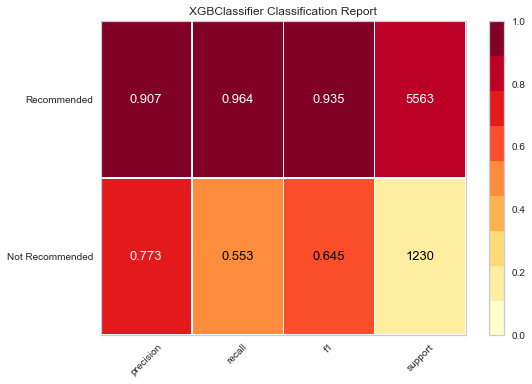

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [228]:
visualizer = ClassificationReport(xgb, classes=['Not Recommended', 'Recommended'], support=True, )

visualizer.fit(train_feature_set.toarray(), y_train)  # Fit the visualizer and the model
visualizer.score(test_feature_set.toarray(), y_test)# Evaluate the model on the test data
for label in visualizer.ax.texts:
    label.set_size(13)
plt.savefig('images/bestxgb.png', dpi=300)
visualizer.show()  

In [163]:
# Naive Bayes
gnb = GaussianNB()
model_predictions(gnb,train_feature_set.toarray(),y_train, test_feature_set.toarray(), y_test)

GaussianNB()
Accuracy: 0.644
Confusion Matrix:  
 [[ 549  681]
 [ 831 4732]]
Classification Report 
               precision    recall  f1-score   support

           0       0.40      0.45      0.42      1230
           1       0.87      0.85      0.86      5563

    accuracy                           0.78      6793
   macro avg       0.64      0.65      0.64      6793
weighted avg       0.79      0.78      0.78      6793



# Smote

In [77]:
tv = TfidfVectorizer(stop_words=sw, ngram_range=(1,2), max_features=10000)
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

In [78]:

smote=SMOTE()

X_train_sm, y_train_sm = smote.fit_resample(train_feature_set,y_train)
#X_test_sm, y_test_sm = smote.fit_resample(test_feature_set,y_test)

In [83]:
lr = LogisticRegression()
model_predictions(lr,X_train_sm,y_train_sm, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.929
Confusion Matrix:  
 [[ 408  822]
 [  61 5502]]
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.33      0.48      1230
           1       0.87      0.99      0.93      5563

    accuracy                           0.87      6793
   macro avg       0.87      0.66      0.70      6793
weighted avg       0.87      0.87      0.85      6793



In [85]:
rf = RandomForestClassifier()
model_predictions(rf,X_train_sm,y_train_sm,test_feature_set, y_test)

RandomForestClassifier()
Accuracy: 0.945
Confusion Matrix:  
 [[ 329  901]
 [  52 5511]]
Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.27      0.41      1230
           1       0.86      0.99      0.92      5563

    accuracy                           0.86      6793
   macro avg       0.86      0.63      0.66      6793
weighted avg       0.86      0.86      0.83      6793



In [108]:
rf = RandomForestClassifier(n_estimators=20)
model_predictions(rf,X_train_sm,y_train_sm,test_feature_set, y_test)

RandomForestClassifier(n_estimators=20)
Accuracy: 0.929
Confusion Matrix:  
 [[ 377  853]
 [  81 5482]]
Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.31      0.45      1230
           1       0.87      0.99      0.92      5563

    accuracy                           0.86      6793
   macro avg       0.84      0.65      0.68      6793
weighted avg       0.86      0.86      0.84      6793



In [146]:
type(train_feature_set)

scipy.sparse.csr.csr_matrix

In [147]:
smoten=SMOTEN()

X_train_sm, y_train_sm = smoten.fit_resample(train_feature_set.toarray(),y_train)
#X_test_sm, y_test_sm = smote.fit_resample(test_feature_set,y_test)

KeyboardInterrupt: 

## Take out all the 3s

In [88]:
df_no3= df[df['Rating']!=3]

print('main df and clean df shape:',df_no3.shape , df.shape)

# X , y
X = df_no3['Review Text']
y= df_no3["Recommended IND"].values.reshape(-1,1)
print("X.shape:", X.shape, '\t y_shape:', y.shape)


X_train, X_test, y_train, y_test = train_test_split(X , y , stratify =y , test_size = 0.3, random_state= 100)
print('train_test_split:',X_train.shape , X_test.shape,'\t', y_train.shape, y_test.shape)


main df and clean df shape: (19818, 11) (22641, 11)
X.shape: (19818,) 	 y_shape: (19818, 1)
train_test_split: (13872,) (5946,) 	 (13872, 1) (5946, 1)


In [95]:
tv = TfidfVectorizer(binary= True, stop_words=sw, ngram_range=(1,2), max_features=10000)
tv.fit_transform(X_train)
train_feature_set = tv.transform(X_train)
test_feature_set = tv.transform(X_test)

In [96]:
smote=SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(train_feature_set,y_train)

rf = RandomForestClassifier()
model_predictions(rf,X_train_sm,y_train_sm,test_feature_set, y_test)

RandomForestClassifier()
Accuracy: 0.975
Confusion Matrix:  
 [[ 134  600]
 [  19 5193]]
Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.18      0.30       734
           1       0.90      1.00      0.94      5212

    accuracy                           0.90      5946
   macro avg       0.89      0.59      0.62      5946
weighted avg       0.89      0.90      0.86      5946



In [92]:
# With tf-idf
lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.919
Confusion Matrix:  
 [[ 136  598]
 [  11 5201]]
Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.19      0.31       734
           1       0.90      1.00      0.94      5212

    accuracy                           0.90      5946
   macro avg       0.91      0.59      0.63      5946
weighted avg       0.90      0.90      0.87      5946



In [249]:
# with count Vectorizer
cv = CountVectorizer(binary = True, stop_words= 'english',  min_df = 5, max_df = 0.95, ngram_range=(1,2))
cv.fit_transform(X_train)
train_feature_set = cv.transform(X_train)
test_feature_set = cv.transform(X_test)

lr = LogisticRegression()
model_predictions(lr,train_feature_set,y_train, test_feature_set, y_test)

LogisticRegression()
Accuracy: 0.883
Confusion Matrix:  
 [[ 700  530]
 [ 250 5313]]
Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.57      0.64      1230
           1       0.91      0.96      0.93      5563

    accuracy                           0.89      6793
   macro avg       0.82      0.76      0.79      6793
weighted avg       0.88      0.89      0.88      6793



In [256]:
smote=SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(train_feature_set,y_train)
lr = LogisticRegression(penalty='l1', solver='liblinear')
model_predictions(lr,X_train_sm,y_train_sm, test_feature_set, y_test)

LogisticRegression(penalty='l1', solver='liblinear')
Accuracy: 0.877
Confusion Matrix:  
 [[ 712  518]
 [ 275 5288]]
Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.58      0.64      1230
           1       0.91      0.95      0.93      5563

    accuracy                           0.88      6793
   macro avg       0.82      0.76      0.79      6793
weighted avg       0.88      0.88      0.88      6793

